In [ ]:
# This is an implementation of Resnets, an improvement over CNNs for classifying images
# Theoretically, the idea here is to replace convolutional layers, where we replace entire represntations of images, with residual layers
# Where instead of replacing our representations in each layer, we simply perturb it a bit by adding the output of a layer to the output of a previous layer
# This helps solve a problem with neural networks where the gradient grows exponentially, as (f(g(x)))' = f'(g(x))g'(x) for some layers f and g, i.E., we keep multiplying by another factor for each layer
# But (x+f(g(x)))' =1+ f'(g(x))g'(x), which doesn't grow by as much

In [ ]:
#@title
from google.colab import drive
! [ -e /content ] && pip install -Uqq fastbook
! pip install torch-lr-finder
import fastbook
fastbook.setup_book()
from fastai.tabular.all import *

In [ ]:
#@title
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from fastbook import *
import numpy as np

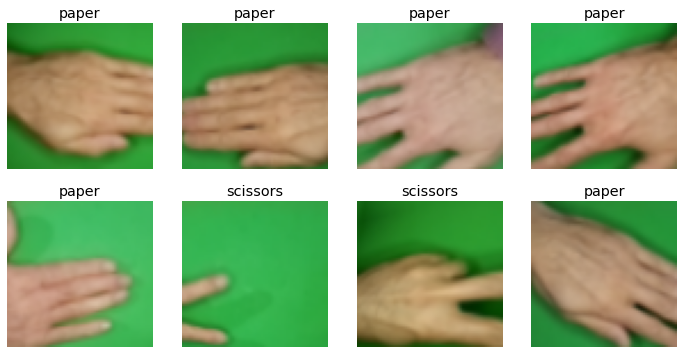

In [ ]:
# Opens path for images. Here I'm classifying rock paper scissors images found on kaggle: https://www.kaggle.com/c/rock-paper-scissors
path = Path("gdrive/MyDrive/Images")

# Image preprocessing and dataloaders creation is done using FastAI. Here I'm resizing images to be 64 by 64, and applying a bunch of data augmentations to increase model accuracy
db = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y= parent_label,
                   splitter = RandomSplitter(),
                   item_tfms=Resize(64),
                   batch_tfms=aug_transforms(size=64, min_scale=0.75)
                   )
dls = db.dataloaders(path, bs = 32)
dls.show_batch(max_n = 9) # Shows sample of our batch

In [ ]:
# Here is our class for residual blocks with skip connections

class resBlock(nn.Module):
    def __init__(self, n, kernel_size = 3, padding=1, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(n, n, kernel_size = kernel_size, padding = padding, stride=stride)
        self.conv2 = nn.Conv2d(n, n, kernel_size = kernel_size, padding = padding, stride=stride)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return self.conv2(x)+x

# Resnet model - this is like a CNN but with residual blocks

model = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size = 8, stride = 4), 
    nn.ReLU(),
    resBlock(64),
    nn.ReLU(),
    resBlock(64),
    nn.ReLU(),
    nn.Conv2d(64, 32, kernel_size = 4, stride = 3),
    nn.ReLU(),
    resBlock(32),
    nn.ReLU(),
    resBlock(32),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(32, 3),
    nn.Softmax()
)

In [ ]:
# Creates a learner in the FastAI libary. They have some nice techniques that improve image classification, such as onecycle fitting and finding learning rates
learner = Learner(dls, model, loss_func= nn.CrossEntropyLoss())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


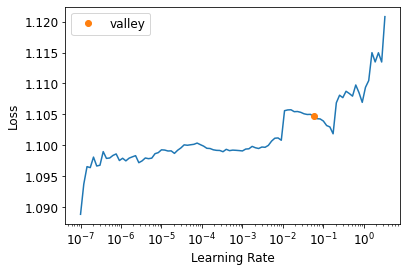

In [ ]:
# Optimal learning rate
alpha = learner.lr_find().valley

In [ ]:
# Fits model for 50  iterations
learner.fit_one_cycle(50, alpha)